Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


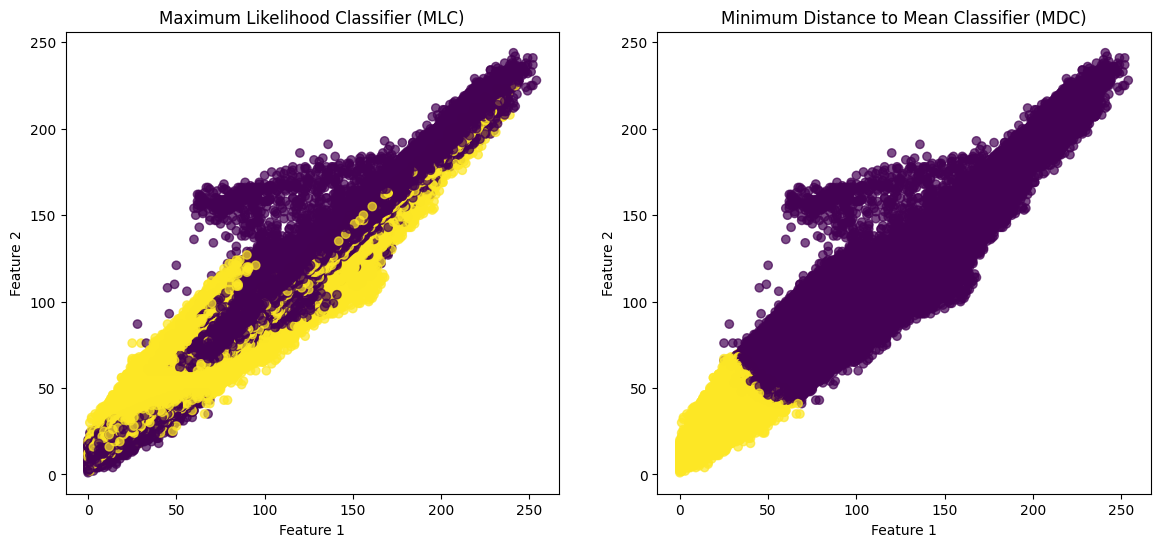

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import rasterio

# Function to load a single .tif image
def load_single_tif_image(image_path):
    with rasterio.open(image_path) as src:
        # Read all bands (assuming the image has more than 1 band)
        image_data = src.read()
        # Flatten image data into 2D array (bands x pixels)
        image_data = image_data.reshape(image_data.shape[0], -1).T  # Each pixel will be a row
    return image_data

# Maximum Likelihood Classifier
def maximum_likelihood_classifier(data, means, covariances):
    likelihoods = [
        multivariate_normal(mean=means[i], cov=covariances[i]).pdf(data)
        for i in range(len(means))
    ]
    return np.argmax(likelihoods, axis=0)

# Minimum Distance to Mean Classifier
def minimum_distance_classifier(data, means):
    distances = [np.linalg.norm(data - mean, axis=1) for mean in means]
    return np.argmin(distances, axis=0)

def main():
    # Mount Google Drive
    drive.mount('/content/drive')

    # Single image path
    image_path = '/content/drive/My Drive/GNR/image.tif'

    # Load the image data
    image_data = load_single_tif_image(image_path)
    labels = np.array([0 if i % 2 == 0 else 1 for i in range(image_data.shape[0])])  # Dummy labels for testing

    if image_data.size == 0 or labels.size == 0:
        raise ValueError("Dataset is empty or improperly loaded.")

    # Ensure labels are a NumPy array
    labels = np.array(labels)

    # Verify dataset
    if len(np.unique(labels)) < 2:
        raise ValueError("Dataset must have at least two classes.")
    if image_data.shape[1] < 2:
        raise ValueError("Images must have at least two features for visualization.")

    # Compute means and covariances for each class
    means = [np.mean(image_data[labels == i], axis=0) for i in np.unique(labels)]
    covariances = [np.cov(image_data[labels == i].T) for i in np.unique(labels)]

    # Regularize covariance matrices
    epsilon = 1e-6
    covariances = [cov + epsilon * np.eye(cov.shape[0]) for cov in covariances]

    # Perform classification
    try:
        mlc_labels = maximum_likelihood_classifier(image_data, means, covariances)
    except np.linalg.LinAlgError as e:
        print("Error in MLC:", e)
        return

    mdc_labels = minimum_distance_classifier(image_data, means)

    # Plot results (for visualization of the first two features if available)
    if image_data.shape[1] > 1:  # Ensure we have more than one feature
        plt.figure(figsize=(14, 6))

        # MLC Results
        plt.subplot(1, 2, 1)
        plt.scatter(image_data[:, 0], image_data[:, 1], c=mlc_labels, cmap='viridis', alpha=0.7)
        plt.title("Maximum Likelihood Classifier (MLC)")
        plt.xlabel("Feature 1")
        plt.ylabel("Feature 2")

        # MDC Results
        plt.subplot(1, 2, 2)
        plt.scatter(image_data[:, 0], image_data[:, 1], c=mdc_labels, cmap='viridis', alpha=0.7)
        plt.title("Minimum Distance to Mean Classifier (MDC)")
        plt.xlabel("Feature 1")
        plt.ylabel("Feature 2")

        plt.show()

main()
